In [0]:
from keras.layers import Convolution2D, MaxPooling2D, LSTM, SeparableConv2D

In [0]:
# Imports
!pip install -q keras opencv-python
import keras
import cv2

from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D, regularizers
from keras.layers import Concatenate
from keras.optimizers import Adam, SGD, Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.initializers import VarianceScaling
from keras.models import load_model
import random
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Connect to Google Drive

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
!ls drive

 3A_Assignment.ipynb	    4_Assignment.ipynb	 model_files32
 3B_Assignment.ipynb	   'Getting started'	 tiny-imagenet-200.zip
 4_32x32_Assignment.ipynb   model_files


# Load data-set 

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

(60000, 28, 28)


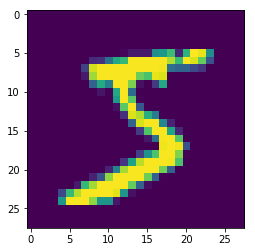

In [0]:
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[0])

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [0]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)


# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
Y_train[:10]


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
# N/W activation after BN. 
from keras.layers import Activation
model = Sequential()

model.add(Convolution2D(10, 3, 3, input_shape=(28,28,1), kernel_regularizer=regularizers.l2(0.01))) # 26
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(16, 3, 3, kernel_regularizer=regularizers.l2(0.01))) # 24
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.20))


model.add(MaxPooling2D(pool_size=(2, 2))) # 12
model.add(Convolution2D(16, 3, 3, kernel_regularizer=regularizers.l2(0.01))) # 10
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.20))


model.add(Convolution2D(16, 3, 3, activation='relu')) # 8
model.add(Dropout(0.20))

model.add(Convolution2D(10, 1, activation='relu')) #8

model.add(Convolution2D(10, 8)) #seeing 7x7 receptive fild
model.add(Flatten())
model.add(Activation('softmax'))


#tuning with learning rate
# from keras.layers import Activation
# model = Sequential()


# model.add(Convolution2D(10, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
# model.add(BatchNormalization())

# model.add(Convolution2D(16, 3, 3, activation='relu')) # 24
# model.add(BatchNormalization())
# model.add(Dropout(0.20))


# model.add(MaxPooling2D(pool_size=(2, 2))) # 12
# model.add(Convolution2D(16, 3, 3, activation='relu')) # 10
# model.add(BatchNormalization())
# model.add(Dropout(0.20))


# model.add(Convolution2D(16, 3, 3, activation='relu')) # 8
# model.add(Dropout(0.20))

# model.add(Convolution2D(10, 1, activation='relu')) #8
# # model.add(BatchNormalization())

# model.add(Convolution2D(10, 8)) #seeing 7x7 receptive fild
# model.add(Flatten())
# model.add(Activation('softmax'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (3, 3), input_shape=(28, 28, 1..., kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), kernel_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 26, 26, 10)        100       
_________________________________________________________________
batch_normalization_41 (Batc (None, 26, 26, 10)        40        
_________________________________________________________________
activation_31 (Activation)   (None, 26, 26, 10)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 24, 24, 16)        1456      
_________________________________________________________________
batch_normalization_42 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
activation_32 (Activation)   (None, 24, 24, 16)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 24, 24, 16)        0         
__________

In [0]:
# Arguments for Image genrator 
datagen = ImageDataGenerator(featurewise_center=True)


In [0]:
# Fitting Augumentation to train-data to data genrator.
datagen.fit(X_train)
x_aug = datagen.flow(X_train, Y_train, batch_size=32)

In [0]:
# learninh ret on epoch wise.
def lr_schedule(epoch):
    lrate = 0.01
    if epoch > 10:
        lrate = 0.01
    elif epoch > 20:
        lrate = 0.01       
    return lrate
LR_scheduler = LearningRateScheduler(lr_schedule)

In [0]:

#

In [0]:
#Complile model.
# lr_rate = 0.001
# optimizer = Nadam(lr_rate)
# model.compile(loss='categorical_crossentropy',
#              optimizer=optimizer,
#              metrics=['accuracy'])


model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.001, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [0]:
# model.compile(loss='categorical_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping =EarlyStopping(monitor='val_loss', patience=5)

In [0]:
# Save model file to google drive with best accuracy.
filepath="drive/model_files32/EVA1assgn5.hdf5"
# filepath="drive/model_files32/1stbatch1assgn4-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, LR_scheduler]

In [0]:
# model.fit(X_train, Y_train, batch_size=32, nb_epoch=30, verbose=1, validation_data=(X_test, Y_test), callbacks=callbacks_list)

In [0]:
#Fifing all augument to fit_genrator with validation data.

model.fit_generator(
    x_aug, steps_per_epoch=4000, epochs=30,
    verbose=1, validation_data=(X_test, Y_test), callbacks=callbacks_list
)

Epoch 1/30
4000/4000 [==============================] - 37s 9ms/step - loss: 0.3726 - acc: 0.9315 - val_loss: 0.1795 - val_acc: 0.9652

Epoch 00001: val_acc improved from -inf to 0.96520, saving model to drive/model_files32/EVA1assgn5.hdf5
Epoch 2/30
4000/4000 [==============================] - 34s 9ms/step - loss: 0.1229 - acc: 0.9755 - val_loss: 0.3712 - val_acc: 0.8748

Epoch 00002: val_acc did not improve from 0.96520
Epoch 3/30
4000/4000 [==============================] - 34s 9ms/step - loss: 0.0880 - acc: 0.9787 - val_loss: 0.0930 - val_acc: 0.9757

Epoch 00003: val_acc improved from 0.96520 to 0.97570, saving model to drive/model_files32/EVA1assgn5.hdf5
Epoch 4/30
4000/4000 [==============================] - 34s 9ms/step - loss: 0.0775 - acc: 0.9810 - val_loss: 0.0907 - val_acc: 0.9782

Epoch 00004: val_acc improved from 0.97570 to 0.97820, saving model to drive/model_files32/EVA1assgn5.hdf5
Epoch 5/30
4000/4000 [==============================] - 35s 9ms/step - loss: 0.0729 - ac

In [0]:
model.fit_generator(
    x_aug, steps_per_epoch=4000, epochs=10,
    verbose=1, validation_data=(X_test, Y_test), callbacks=callbacks_list
)

Epoch 1/10
4000/4000 [==============================] - 30s 7ms/step - loss: 0.0451 - acc: 0.9896 - val_loss: 0.0547 - val_acc: 0.9873

Epoch 00001: val_acc did not improve from 0.99140
Epoch 2/10
4000/4000 [==============================] - 30s 7ms/step - loss: 0.0446 - acc: 0.9895 - val_loss: 0.0485 - val_acc: 0.9890

Epoch 00002: val_acc did not improve from 0.99140
Epoch 3/10
4000/4000 [==============================] - 29s 7ms/step - loss: 0.0436 - acc: 0.9898 - val_loss: 0.1440 - val_acc: 0.9531

Epoch 00003: val_acc did not improve from 0.99140
Epoch 4/10
4000/4000 [==============================] - 29s 7ms/step - loss: 0.0434 - acc: 0.9901 - val_loss: 0.0581 - val_acc: 0.9855

Epoch 00004: val_acc did not improve from 0.99140
Epoch 5/10
4000/4000 [==============================] - 30s 7ms/step - loss: 0.0435 - acc: 0.9898 - val_loss: 0.0469 - val_acc: 0.9905

Epoch 00005: val_acc did not improve from 0.99140
Epoch 6/10
4000/4000 [==============================] - 29s 7ms/step -

In [0]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.041093995632231234, 0.9912]


In [0]:
predictions = model.predict(X_test)

In [0]:
# Taking all miss-clasified images index.
import numpy as np 
import numpy
import matplotlib.pyplot as plt
index = 0
misclassifiedIndexes = []
for label, predict in zip(Y_test, predictions):
#   print(label)  
  predict = numpy.where(predict == numpy.amax(predict))[0][0]
  label = numpy.where(label == numpy.amax(label))[0][0]
  
  if label != predict: 
#     print(predict, label)
#     misclassifiedIndexes.append(index)
    misclassifiedIndexes.append([index, (label, predict)])
  index +=1

In [0]:
Y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

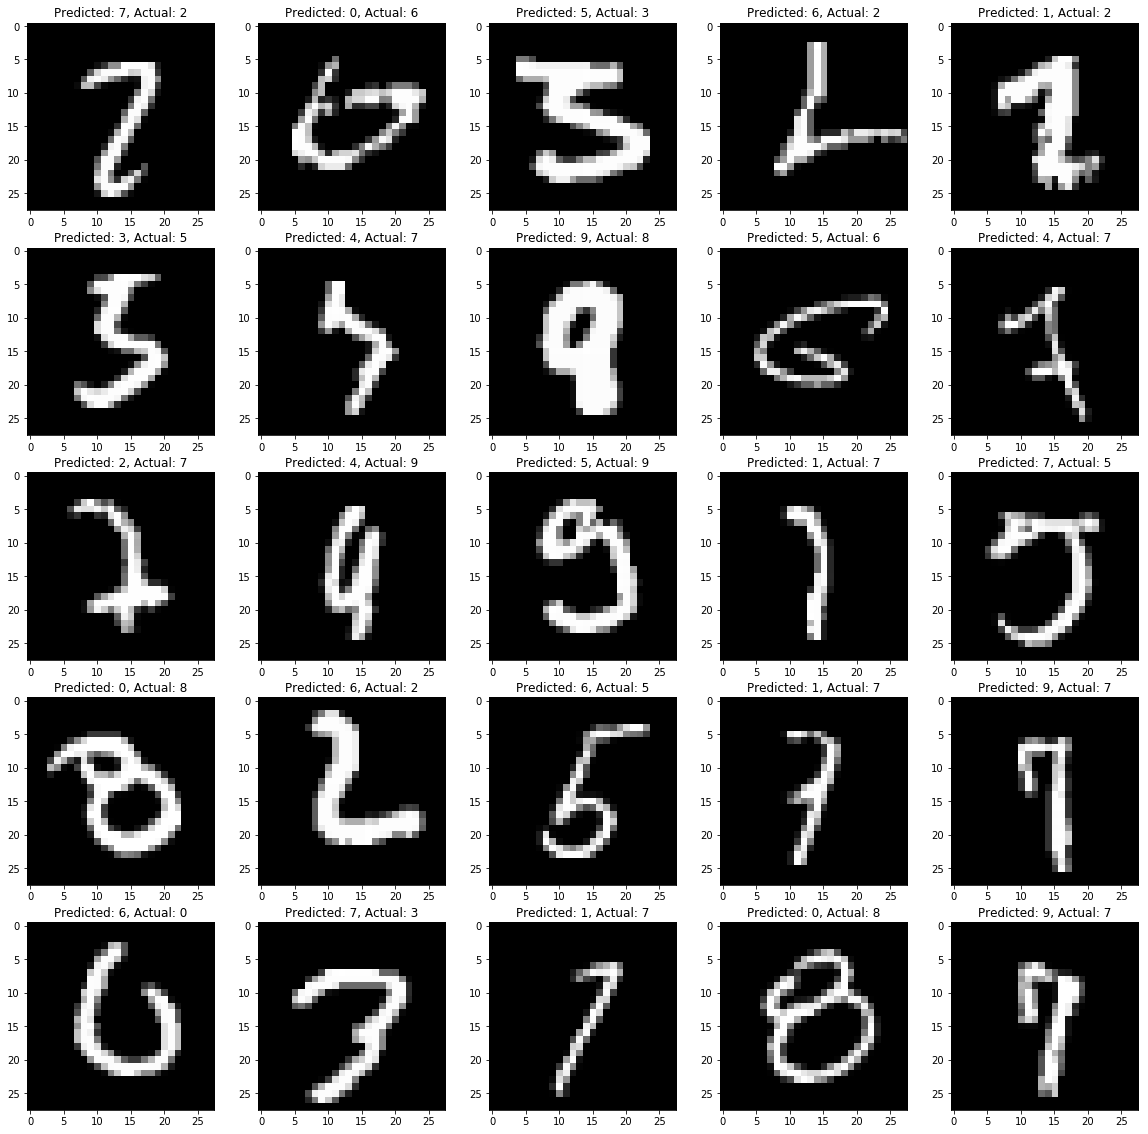

In [0]:
# ploating all images to 5 x 5 in dimenssion 
plt.figure(figsize=(20,20))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:25]):

  plt.subplot(5, 5, plotIndex+1)
#   nrows=2, ncols=2
#   plt.subplot(nrows=1, ncols=1)
  plt.imshow(np.reshape(X_test[badIndex[0]], (28,28)), cmap=plt.cm.gray)
  kk = badIndex[1][0]
  mm = badIndex[1][1]
  plt.title("Predicted: {}, Actual: {}".format(mm, kk, fontsize = 15))

[link text](https://alyxion.github.io/Udacity_IntroToSelfDrivingCarsNd//8_1_Day_Night_Classification_Mini_Projects/47_Accuracy%20and%20Misclassification.html)